# TAOS mars3D: overview

First look at data

In [18]:
import numpy as np
import xarray as xr
import pandas as pd

import dask
from dask import delayed

from matplotlib import pyplot as plt
%matplotlib inline

from taos import mars as ms

In [19]:
if True:
    
    from dask.distributed import Client
    from dask_jobqueue import PBSCluster

    cluster = PBSCluster()
    #cluster = PBSCluster(processes=4, cores=4) # std
    
    w = cluster.scale(jobs=5)
    
    client = Client(cluster)
    client
else:
    from dask.distributed import Client, LocalCluster
    #
    cluster = LocalCluster()
    client = Client(cluster)
    client

In [20]:
client

Connection method: Cluster object,Cluster type: PBSCluster
Dashboard: http://10.148.0.255:8787/status,
Dashboard: http://10.148.0.255:8787/status,Workers: 0
Total threads: 0,Total memory: 0 B
Comm: tcp://10.148.0.255:38470,Workers: 0
Dashboard: http://10.148.0.255:8787/status,Total threads: 0
Started: Just now,Total memory: 0 B


---

## load data subset

In [21]:
# select a region, here California
year = "2010"

files = ms.browse_files(year)
print("Number of data files = {} ".format(len(files)))

Number of data files = 8974 


In [8]:
# select 4 times spread over 2010
files_selected = [files.loc["2010-{:2d}-01 01:00:00".format(n), "files"] for n in range(1,12, 3)]
ds = xr.concat([xr.open_dataset(f) for f in files_selected], dim="time")

# add vertical coordinate and eos variables
ds = ds.assign_coords(z = ms.get_z(ds).transpose("time", "level", "nj", "ni"))
ds = ms.add_eos(ds)

---

### plot snapshots of surface fields

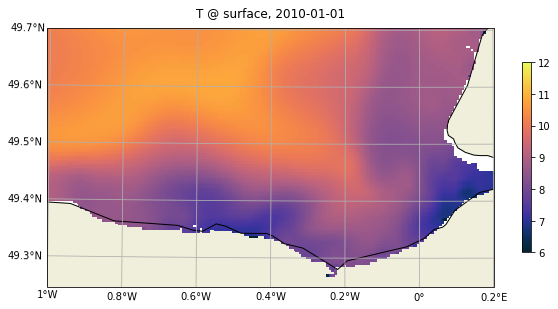

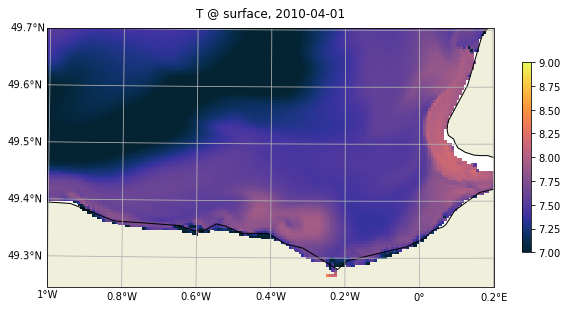

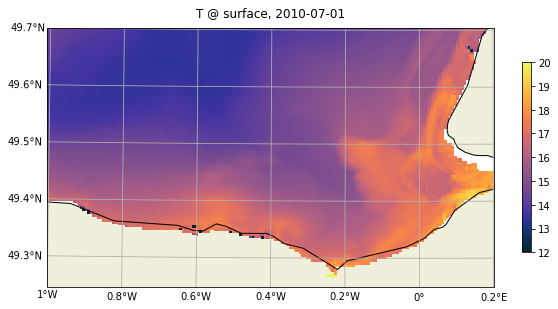

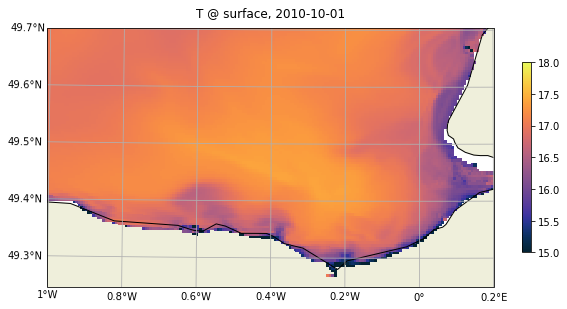

In [9]:
clims = [[6,12], [7,9], [12,20], [15, 18]]
for t, clim in zip(ds.time, clims):
    ms.plot_bs(ds["TEMP"].sel(time=t, level=0, method="nearest"), 
               title="T @ surface, "+str(t.dt.strftime("%Y-%m-%d").values),
               vmin=clim[0], vmax=clim[1],
               cmap=ms.cm.thermal,
               zoom=1, figsize=0,
              )

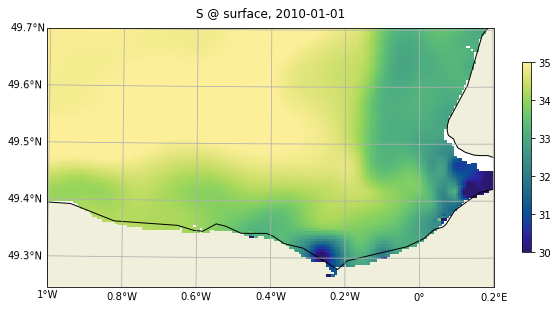

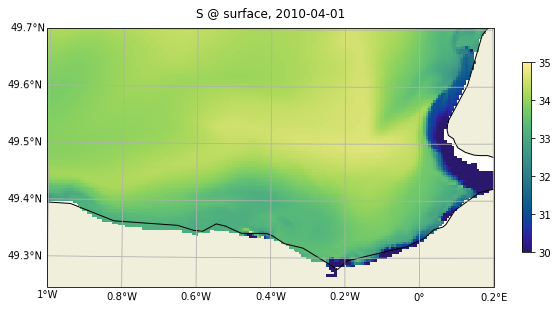

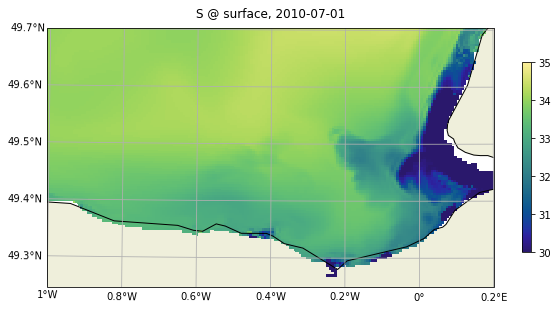

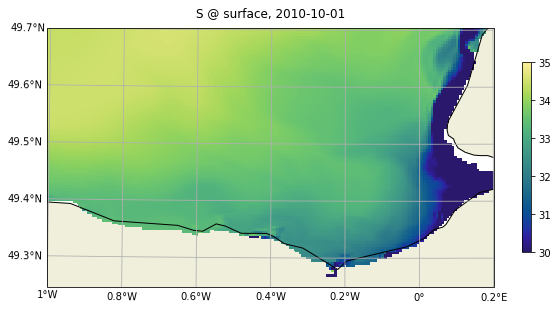

In [10]:
for t, clim in zip(ds.time, clims):
    ms.plot_bs(ds["SAL"].sel(time=t, level=0, method="nearest"), 
               title="S @ surface, "+str(t.dt.strftime("%Y-%m-%d").values),
               vmin=30, vmax=35,
               cmap=ms.cm.haline,
               zoom=1, figsize=0,
              )

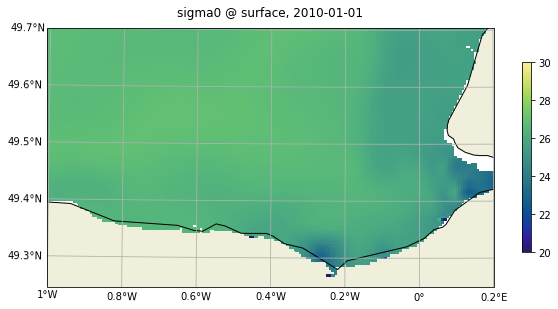

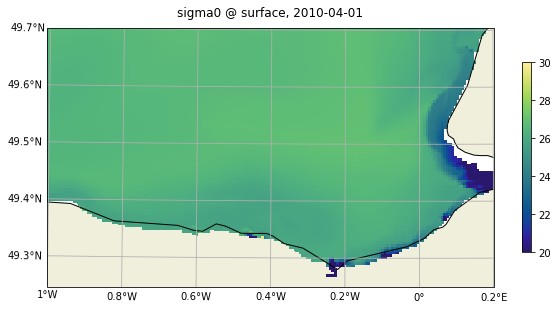

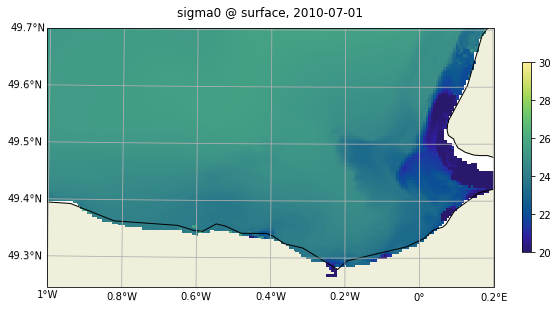

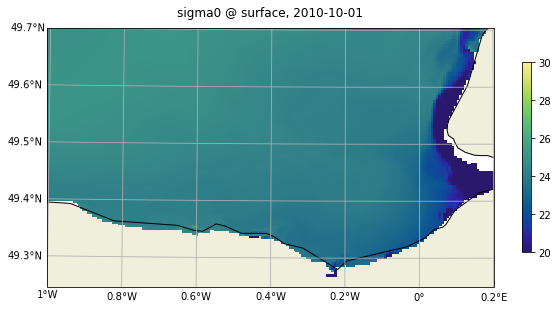

In [11]:
for t, clim in zip(ds.time, clims):
    ms.plot_bs(ds["sigma0"].sel(time=t, level=0, method="nearest"), 
               title="sigma0 @ surface, "+str(t.dt.strftime("%Y-%m-%d").values),
               vmin=20, vmax=30,
               cmap=ms.cm.haline,
               zoom=1, figsize=0,
              )

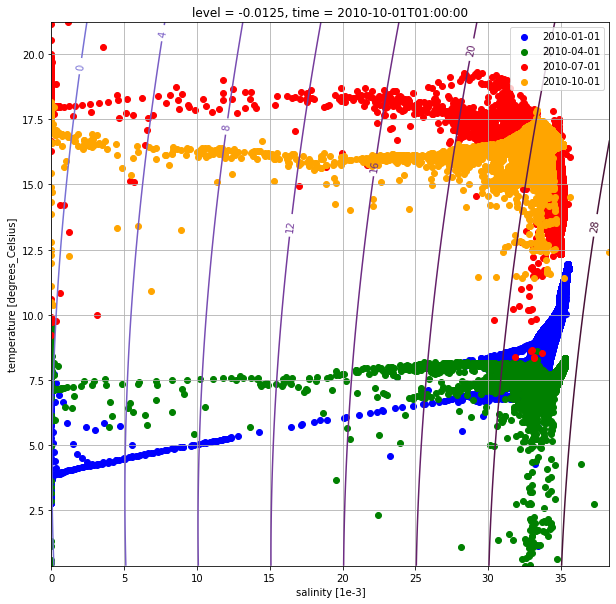

In [12]:
_ds = ds.sel(level=0, method="nearest")
colors = ["b", "g", "r", "orange"]

fig, ax = ms.TS_plot(_ds, t_range=None, s_range=None, figsize=(10,10))

for t, c in zip(_ds.time, colors):
    _dst = _ds.sel(time=t)
    xr.plot.scatter(_dst, y="TEMP", x="SAL", ax=ax, color=c, label=str(t.dt.strftime("%Y-%m-%d").values))
ax.legend()

---

### vertical slices

In [13]:
#i, j = 200, 40
#ds["TEMP"].isel(ni=i, nj=j).plot(y="z")

---

### make figures for movie


In [22]:
def gen_fig(f, v=None, **kwargs):
        
    #dask.config.set(scheduler="threads")
    
    # load and massage file
    ds = xr.open_dataset(f)

    # add vertical coordinate and eos variables
    ds = ds.assign_coords(z = ms.get_z(ds).transpose("time", "level", "nj", "ni"))
    ds = ms.add_eos(ds)

    #
    out_dir = "/home1/scratch/aponte/figs/"
    fig_path = out_dir+ds.time.dt.strftime("%Y-%m-%d_%H%M%S").values[0]+".png"
    
    ms.plot_bs(ds[v].sel(level=0, method="nearest"),
               title=v+" @ surface, "+str(ds.time.dt.strftime("%Y-%m-%d %H:%M:%S").values),
               offline=True,
               savefig=fig_path,
               **kwargs
              )
    
    return fig_path

from dask.delayed import delayed
delayed_fig = delayed(gen_fig)

In [33]:
#

file_subset = files["2010-01-01":"2010-02-01"]

#
#kwargs = dict(v="TEMP", cmap=ms.cm.thermal) # need to be redone
#kwargs = dict(v="TEMP", zoom=1, cmap=ms.cm.thermal)
#kwargs = dict(v="SAL", vmin=30, vmax=35, cmap=ms.cm.haline)
kwargs = dict(v="SAL", zoom=1, vmin=30, vmax=35, cmap=ms.cm.haline)

In [34]:
#
Nb = len(client.nthreads())
rg = range(0, file_subset.size)
if len(rg)/Nb>1:
    II = np.array_split(rg,len(rg)/Nb)
else:
    II = [list(rg)]
print('%d batches to be done'%len(II))

for I in II:
    print(' batch %d-%d'%(I[0],I[-1]))
    values = [delayed_fig(file_subset.iloc[i,0], **kwargs) for i in I]
    futures = client.compute(values)
    results = client.gather(futures)

print(" ! done !")

21 batches to be done
 batch 0-36
 batch 37-73
 batch 74-110
 batch 111-147
 batch 148-184
 batch 185-221
 batch 222-258
 batch 259-295
 batch 296-332
 batch 333-369
 batch 370-406
 batch 407-442
 batch 443-478
 batch 479-514
 batch 515-550
 batch 551-586
 batch 587-622
 batch 623-658
 batch 659-694
 batch 695-730
 batch 731-766
 ! done !


---

In [ ]:
client.restart()

In [35]:
cluster.close()

/home1/datahome/aponte/.miniconda3/envs/equinox/lib/python3.8/site-packages/dask_jobqueue/core.py:360: FutureWarning: ignoring was deprecated in version 2021.06.1 and will be removed in a future release. Please use contextlib.suppress from the standard library instead.
  with ignoring(RuntimeError):  # deleting job when job already gone
/home1/datahome/aponte/.miniconda3/envs/equinox/lib/python3.8/site-packages/dask_jobqueue/core.py:360: FutureWarning: ignoring was deprecated in version 2021.06.1 and will be removed in a future release. Please use contextlib.suppress from the standard library instead.
  with ignoring(RuntimeError):  # deleting job when job already gone
/home1/datahome/aponte/.miniconda3/envs/equinox/lib/python3.8/site-packages/dask_jobqueue/core.py:360: FutureWarning: ignoring was deprecated in version 2021.06.1 and will be removed in a future release. Please use contextlib.suppress from the standard library instead.
  with ignoring(RuntimeError):  # deleting job when 

In [15]:
for f in futures:
    f.cancel()